<a href="https://colab.research.google.com/github/ttogle918/NLU_3-/blob/main/%EC%9A%B0%EA%B2%BD%ED%99%94_sts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLU - 문장 유사도 계산 (STS)**

## **과제 목표**

- 두 개의 한국어 문장을 입력받아 두 문장의 의미적 유사도를 출력
- regression task (0 ≤ target ≤ 5)

## **학습 데이터셋(Dataset description)**

- [KLUE-STS](https://klue-benchmark.com/tasks/67/data/download)
  - AIRBNB (에어비앤비 리뷰)
  - policy (정책 뉴스)
  - paraKOQC (스마트홈 쿼리)

  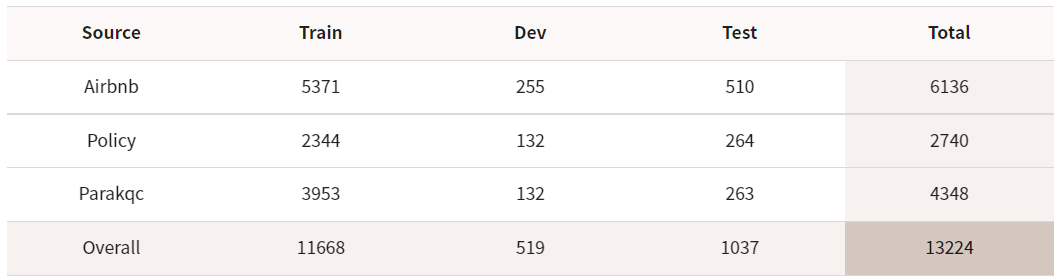

## **과제 결과물**
- 학습된 모델 (모델 자유 선택) (train set만 사용해 학습)
- 학습 방식 보고서
 - 어떤 모델을 선택했나
 - 어떻게 파라미터를 튜닝했나
 - 어떤 훈련 과정을 거쳤는가
- dev set score (F1)
- 문장 유사도를 출력하는 API (프레임워크 자유 선택)

## **설치 및 설정(Set up)**

In [ ]:
# Hugging Face의 트랜스포머 모델 설치
!pip install transformers
!pip install sentence_transformers datasets
!pip install datasets

In [ ]:
# tensorboard 패키지 설치
!pip install jupyter-tensorboard

In [3]:
# 라이브러리
import os
import sys
import re
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import math
import logging
import time
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import AdamW
from datasets import load_dataset, load_metric
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import get_linear_schedule_with_warmup

In [4]:
# seed
seed = 7777
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# device type 확인
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla T4
cuda


In [5]:
# logger
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)

## **데이터셋 불러오기(Load Dataset)**
- STS 데이터는 두 개의 문장 쌍과 이 두 문장 사이의 유사도 점수로 구성됨.
- STS데이터를 학습하여 문장과 문장간 서로 얼마나 유사한지를 예측.

### KLUE-STS 데이터셋
- [KLUE-STS](https://klue-benchmark.com/tasks/67/data/download)

In [6]:
# KLUE-STS 데이터셋 다운로드
#dataset = load_dataset('klue', 'sts')
klue_sts_train = load_dataset("klue", "sts", split='train[:90%]')
klue_sts_valid = load_dataset("klue", "sts", split='train[-10%:]') # train의 10%를 validation set으로 사용
klue_sts_test = load_dataset("klue", "sts", split='validation')

Generating train split:   0%|          | 0/11668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/519 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.
2022-06-01 21:10:09 - Reusing dataset klue (/root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)
2022-06-01 21:10:11 - Reusing dataset klue (/root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)


In [7]:
print(f'shape : train {klue_sts_train.shape}, valid {klue_sts_valid.shape}, test {klue_sts_test.shape}')

shape : train (10501, 5), valid (1167, 5), test (519, 5)


In [8]:
# dataset 데이터셋 중 train 첫째 줄 내용
klue_sts_train[0]

{'guid': 'klue-sts-v1_train_00000',
 'labels': {'binary-label': 1, 'label': 3.7, 'real-label': 3.714285714285714},
 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
 'source': 'airbnb-rtt'}

In [9]:
# dataset 데이터셋 중 validation 첫째 줄 내용
klue_sts_valid[0]

{'guid': 'klue-sts-v1_train_10501',
 'labels': {'binary-label': 0, 'label': 0.0, 'real-label': 0.0},
 'sentence1': '지난해 대비 TV 등 3개 품목이 추가됐다.',
 'sentence2': '특히 재활용산업육성자금은 전년 대비 350억 원이 증액됐다.',
 'source': 'policy-sampled'}

## **데이터 전처리(Data Preprocessing)**

In [10]:
# 파라미터 정의 
task = "sts"
model_checkpoint = "klue/roberta-base"
batch_size = 32

In [11]:
# klue/roberta-base tokenizer 불러오기 
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [12]:
# real-label을 label로 변경 
klue_sts_train = klue_sts_train.flatten()
klue_sts_train = klue_sts_train.rename_column('labels.real-label','label')
klue_sts_valid = klue_sts_valid.flatten()
klue_sts_valid = klue_sts_valid.rename_column('labels.real-label','label')
klue_sts_test = klue_sts_test.flatten()
klue_sts_test = klue_sts_test.rename_column('labels.real-label','label')

In [13]:
# 모델 입력으로 만들어 주는 전처리 함수 
# truncation으로 길이 넘어가면 자를 수 있게 설정
# padding 으로 길이 맞춰주기 
def preprocess_function(dataset):
    return tokenizer(dataset['sentence1'], dataset['sentence2'], truncation=True, max_length=512, padding=True)

In [14]:
# 전처리 함수 각 데이터셋에 적용 
encoded_train = klue_sts_train.map(preprocess_function, batched=True)
encoded_valid = klue_sts_valid.map(preprocess_function, batched=True)
encoded_test = klue_sts_test.map(preprocess_function, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]



---


## **모델 훈련 & 모델 평가(Model Training & Model Evaluation)**


###**Model : klue/roberta-base**
batch_size : 32

In [15]:
num_labels = 1

# model : klue/roberta-base 사용
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'class

In [16]:
# 텐서보드 dir 정의 
logdir_path = "/content/drive/MyDrive/Colab Notebooks/NLP with 파이토치/nlp/logs" # log 파일을 저장할 경로를 지정
logdir_path = os.path.join(logdir_path, "sts_log") # 이번 프로젝트 로그를 저장할 파일 경로 정의
writer = SummaryWriter(logdir_path) 

In [17]:
# 베이스 라인 모델 : batch_size= 32, 나머지는 default

output_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/NLP with 파이토치/nlp", "sts")

args = TrainingArguments(
    # checkpoint
    output_dir=output_dir,

    # Model Save & Load
    save_strategy = "epoch", # 각 epoch 마지막에 저장 
    load_best_model_at_end=True, # train 종료시 best model 로드할지 여부

    # Dataset
    num_train_epochs=4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    
    # Evaluation 
    evaluation_strategy = "epoch",# 각 epoch 마지막에 평가

    # Randomness
    seed=42
)

In [18]:
# f1과 pearson 메트릭 불러오기 
metric_f1 = load_metric("f1") 
metric_pearson = load_metric("pearsonr") 

In [19]:
# metric: pearsonr, F1 score
metric_name = "pearsonr"
metric_pearsonr = load_metric(metric_name) # peason r
metric_name2 = "f1"
metric_f1 = load_metric(metric_name2) # f1

In [20]:
# 출력시 메트릭 정의 하는 함수 
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions[:, 0]

    # 3.0 이상 -> '1' , 3.0 미만 -> '0'으로 변환
    predict_f1 = [1 if i>=3.0 else 0 for i in predictions] 
    labels_f1 = [1 if i>=3.0 else 0 for i in labels]

    # peason r 계산
    peason_r = metric_pearson.compute(predictions=predictions, references=labels)

    # f1
    f1 = metric_f1.compute(predictions=predict_f1, references=labels_f1)

    return {'pearsonr' : peason_r, 'f1' : f1}

In [21]:
# trainer 
trainer = Trainer(
    model,
    args,
    train_dataset = encoded_train,
    eval_dataset = encoded_valid,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 1)]
)

In [22]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10501
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1316


Epoch,Training Loss,Validation Loss,Pearsonr,F1
1,No log,0.292051,{'pearsonr': 0.9707647775601107},{'f1': 0.9508771929824562}
2,0.388800,0.172854,{'pearsonr': 0.9746129190102996},{'f1': 0.9597855227882036}
3,0.388800,0.191283,{'pearsonr': 0.9785844701147103},{'f1': 0.9590747330960854}


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1167
  Batch size = 32
Trainer is attempting to log a value of "{'pearsonr': 0.9707647775601107}" of type <class 'dict'> for key "eval/pearsonr" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9508771929824562}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/NLP with 파이토치/nlp/s

TrainOutput(global_step=987, training_loss=0.25219582400181856, metrics={'train_runtime': 680.4428, 'train_samples_per_second': 61.73, 'train_steps_per_second': 1.934, 'total_flos': 2038396057643070.0, 'train_loss': 0.25219582400181856, 'epoch': 3.0})

In [23]:
# baseline score
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1167
  Batch size = 32


Trainer is attempting to log a value of "{'pearsonr': 0.9746129190102996}" of type <class 'dict'> for key "eval/pearsonr" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9597855227882036}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 3.0,
 'eval_f1': {'f1': 0.9597855227882036},
 'eval_loss': 0.17285382747650146,
 'eval_pearsonr': {'pearsonr': 0.9746129190102996},
 'eval_runtime': 7.0541,
 'eval_samples_per_second': 165.435,
 'eval_steps_per_second': 5.245}

In [24]:
# test set으로 prediction 
predictions = trainer.predict(encoded_test)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 519
  Batch size = 32


In [25]:
# test set score 
predictions.metrics

{'test_f1': {'f1': 0.8495934959349595},
 'test_loss': 0.41511061787605286,
 'test_pearsonr': {'pearsonr': 0.9092805311609943},
 'test_runtime': 3.2509,
 'test_samples_per_second': 159.649,
 'test_steps_per_second': 5.229}



---


###**Model : klue/roberta-base**
batch_size : 16

In [26]:
# batch_size= 16

output_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/NLP with 파이토치/nlp", "sts")

batch_args = TrainingArguments(
    # checkpoint
    output_dir = output_dir,

    # Model Save & Load
    save_strategy = "epoch", # 각 epoch 마지막에 저장 
    load_best_model_at_end = True, # train 종료시 best model 로드할지 여부

    # Dataset
    num_train_epochs = 4,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    
    # Optimizer (AdamW)
    learning_rate =  5e-5,
    warmup_steps = 200, 
    weight_decay = 0.01,

    # Evaluation 
    evaluation_strategy = "epoch",# 각 epoch 마지막에 평가

    # Randomness
    seed = 42
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [27]:
# optimizer 및 scheduler 설정: 16
optimizer = AdamW(
    model.parameters(),
    lr = 5e-5,
    eps = 1e-8
)

batch_size = 16
total_steps = round(len(encoded_train.shard(index=1, num_shards=10)) / batch_size) * 5

# lr 선형으로 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [28]:
# batch_size : 16
trainer = Trainer(
    model,
    args = batch_args,
    train_dataset = encoded_train ,
    eval_dataset = encoded_valid,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    optimizers = (optimizer, scheduler),
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 1)]
)

In [29]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 10501
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2628


Epoch,Training Loss,Validation Loss,Pearsonr,F1
1,0.120800,0.171174,{'pearsonr': 0.9761494725561198},{'f1': 0.9566003616636528}
2,0.089300,0.171174,{'pearsonr': 0.9761494725561198},{'f1': 0.9566003616636528}


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1167
  Batch size = 16
Trainer is attempting to log a value of "{'pearsonr': 0.9761494725561198}" of type <class 'dict'> for key "eval/pearsonr" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9566003616636528}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/NLP with 파이토치/nlp/s

TrainOutput(global_step=1314, training_loss=0.10093667191457531, metrics={'train_runtime': 482.3235, 'train_samples_per_second': 87.087, 'train_steps_per_second': 5.449, 'total_flos': 1354533912171084.0, 'train_loss': 0.10093667191457531, 'epoch': 2.0})

In [30]:
# score
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1167
  Batch size = 16


Trainer is attempting to log a value of "{'pearsonr': 0.9761494725561198}" of type <class 'dict'> for key "eval/pearsonr" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9566003616636528}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 2.0,
 'eval_f1': {'f1': 0.9566003616636528},
 'eval_loss': 0.1711743026971817,
 'eval_pearsonr': {'pearsonr': 0.9761494725561198},
 'eval_runtime': 7.3788,
 'eval_samples_per_second': 158.156,
 'eval_steps_per_second': 9.893}



---


###**Model : klue/roberta-base**
batch_size : 32

In [31]:
# batch_size= 32

output_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/NLP with 파이토치/nlp", "sts")

batch_args = TrainingArguments(
    # checkpoint
    output_dir = output_dir,

    # Model Save & Load
    save_strategy = "epoch", # 각 epoch 마지막에 저장 
    load_best_model_at_end = True, # train 종료시 best model 로드할지 여부

    # Dataset
    num_train_epochs = 4,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    
    # Optimizer (AdamW)
    learning_rate =  5e-5,
    warmup_steps = 200,
    weight_decay = 0.01,

    # Evaluation 
    evaluation_strategy = "epoch",# 각 epoch 마지막에 평가

    # Randomness
    seed = 42
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [32]:
# optimizer 및 scheduler 설정: 32
optimizer = AdamW(
    model.parameters(),
    lr = 5e-5,
    eps = 1e-8
)

batch_size = 32
total_steps = round(len(encoded_train.shard(index=1, num_shards=10)) / batch_size) * 5

# lr 선형으로 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [33]:
# batch_size : 32
trainer = Trainer(
    model,
    args = batch_args,
    train_dataset = encoded_train ,
    eval_dataset = encoded_valid,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    optimizers = (optimizer, scheduler),
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 1)]
)

In [34]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 10501
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1316


Epoch,Training Loss,Validation Loss,Pearsonr,F1
1,No log,0.159081,{'pearsonr': 0.9778043280043923},{'f1': 0.9592760180995474}
2,0.086900,0.159081,{'pearsonr': 0.9778043280043923},{'f1': 0.9592760180995474}


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1167
  Batch size = 32
Trainer is attempting to log a value of "{'pearsonr': 0.9778043280043923}" of type <class 'dict'> for key "eval/pearsonr" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9592760180995474}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/NLP with 파이토치/nlp/s

TrainOutput(global_step=658, training_loss=0.0819314055167433, metrics={'train_runtime': 457.1567, 'train_samples_per_second': 91.881, 'train_steps_per_second': 2.879, 'total_flos': 1359072537125196.0, 'train_loss': 0.0819314055167433, 'epoch': 2.0})

In [35]:
# score
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1167
  Batch size = 32


Trainer is attempting to log a value of "{'pearsonr': 0.9778043280043923}" of type <class 'dict'> for key "eval/pearsonr" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9592760180995474}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 2.0,
 'eval_f1': {'f1': 0.9592760180995474},
 'eval_loss': 0.1590813398361206,
 'eval_pearsonr': {'pearsonr': 0.9778043280043923},
 'eval_runtime': 7.0474,
 'eval_samples_per_second': 165.593,
 'eval_steps_per_second': 5.25}



---


###**Model : klue/roberta-base**
batch_size : 64

In [36]:
# batch_size= 64

output_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/NLP with 파이토치/nlp", "sts")

batch_args = TrainingArguments(
    # checkpoint
    output_dir = output_dir,

    # Model Save & Load
    save_strategy = "epoch", # 각 epoch 마지막에 저장 
    load_best_model_at_end = True, # train 종료시 best model 로드할지 여부

    # Dataset
    num_train_epochs = 4,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 64,
    
    # Optimizer (AdamW)
    learning_rate =  5e-5,
    warmup_steps = 200,
    weight_decay = 0.01,

    # Evaluation 
    evaluation_strategy = "epoch",# 각 epoch 마지막에 평가

    # Randomness
    seed = 42
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [37]:
# optimizer 및 scheduler 설정: 64
optimizer = AdamW(
    model.parameters(),
    lr = 5e-5,
    eps = 1e-8
)

batch_size = 64
total_steps = round(len(encoded_train.shard(index=1, num_shards=10)) / batch_size) * 5

# lr 선형으로 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [38]:
# batch_size : 64
trainer = Trainer(
    model,
    args = batch_args,
    train_dataset = encoded_train ,
    eval_dataset = encoded_valid,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    optimizers = (optimizer, scheduler),
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 1)]
)

In [39]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 10501
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 660


Epoch,Training Loss,Validation Loss,Pearsonr,F1
1,No log,0.176367,{'pearsonr': 0.9780379413470249},{'f1': 0.9607142857142857}
2,No log,0.176367,{'pearsonr': 0.9780379413470249},{'f1': 0.9607142857142857}


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1167
  Batch size = 64
Trainer is attempting to log a value of "{'pearsonr': 0.9780379413470249}" of type <class 'dict'> for key "eval/pearsonr" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9607142857142857}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/NLP with 파이토치/nlp/s

TrainOutput(global_step=330, training_loss=0.08469009977398496, metrics={'train_runtime': 429.5889, 'train_samples_per_second': 97.777, 'train_steps_per_second': 1.536, 'total_flos': 1359664531684428.0, 'train_loss': 0.08469009977398496, 'epoch': 2.0})

In [40]:
# score
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: sentence1, source, labels.binary-label, guid, sentence2, labels.label. If sentence1, source, labels.binary-label, guid, sentence2, labels.label are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1167
  Batch size = 64


Trainer is attempting to log a value of "{'pearsonr': 0.9780379413470249}" of type <class 'dict'> for key "eval/pearsonr" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9607142857142857}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 2.0,
 'eval_f1': {'f1': 0.9607142857142857},
 'eval_loss': 0.17636741697788239,
 'eval_pearsonr': {'pearsonr': 0.9780379413470249},
 'eval_runtime': 6.9888,
 'eval_samples_per_second': 166.981,
 'eval_steps_per_second': 2.719}



---



### **Model : klue/roberta-base**
- epochs : 2
- batch_size : train 16
- learning_rate : 5e-5
- weight_decay : 0.01
- loss : 0.1711743026971817
- pearson 상관 계수 : 0.9761494725561198
- f1 : 0.9566003616636528

### **Model : klue/roberta-base**
- epochs : 2
- batch_size : train 32
- learning_rate : 5e-5
- weight_decay : 0.01
- loss : 0.1590813398361206
- pearson 상관 계수 : 0.9778043280043923
- f1 : 0.9592760180995474

### **Model : klue/roberta-base** (가장 성능 좋음)
- epochs : 2
- batch_size : train 64
- learning_rate : 5e-5
- weight_decay : 0.01
- loss : 0.17636741697788239
- pearson 상관 계수 : 0.9780379413470249
- f1 : 0.9607142857142857